# Branching model of cancer incidence

This code simulates a branching process of somatic evolution, with stochastic mutation accumulation and cell
populations undergo logistic growth. Competition between populations is captured through a shared carrying capacity.

V1 [started on 5 March]:
- Intrinsic growth rate given by random samples from a normally-distributed 'g'. Carrying capacity calculated as sum(all other existing populations)-carrying capacity of the focal population.
- Since growth/transition rates are samples from the same distribution, this is the context-independent version of the model.
- Working draft finalised on 17 April.

V2 [started on 15 May]:
- Different form of branching model, with a common carrying capacity that is constant across cell populations, along with density-dependent interaction coefficients, `alpha`, that carry the effect of inter-clone competition.
- Individual values of carrying capacity do not change between populations.
- `alpha` values are assigned pairwise, to each combination of cell populations, within the function, `generate_mutant_pop()`. Each population gets an array of `alpha` values corresponding to each pairwise interaction.
    - New values are generated with every new population, both for the new population, and for the new interaction that is added to the old populations. Therefore, if there are `n` populations including the new mutant, all `alpha` arrays would be `n-1` elements long, with each array updated with the corresponding number of values.
    - **Assumption**: `alpha` values of reciprocal interactions are independent, that is, `alpha(i,j)` and `alpha(j,i)` are assigned independently of each other.
- `k_calculate()` from V1 is dropped in V2, and `generate_mutant_pop()` must include updating the `alpha` matrix with corresponding interaction coefficients.
- `grow_logistically()` calculates size as the sum of intrinsic logistic growth of current population and effect of competitive or facilitative interactions of other populations.
- `drop_dead()` from V1 has been changed to `make_dead()` to make the handling of negative population sizes. `make_dead()` simply sets the growth rate and population size to `0` for those cell populations whose size has declined below `0`.

## Important considerations

- The assumption stated above needs to be examined carefully.
- Are there any *a priori* reasons for the shape of the `alpha` distribution to affect cancer incidence?
- `alpha_matrix` will be an interesting parameter to study; at the end of the simulation, it provides a snapshot of the ecological interaction landscape of tumours in the entire population. Technically, with the shared carrying capacity model, we have shown that cancer progression in the model does not *require* mutualistic interactions between clones. There might however be questions worth pursuing about the interactions of a wider range of ecological behaviours and other basic parameters like the mutation rate.
- Ultimately, this might just end up being another, equivalent way of presenting a more selection-centric rather than a mutation-centric picture.

## Function definitions

In [1]:
# Import of modules
import numpy.random as np
import numpy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from tqdm import tqdm_notebook as tqdm
sns.set()
sns.set_palette(sns.color_palette("viridis", 20))
sns.set_context("paper")
sns.set_style("ticks")

In [3]:
def generate_mutant_pop(population, index, garr, alpha_matrix, alpha_dist):
	"""Updates the 2-D matrices of both the cell populations and corresponding alpha_matrix entries for all interactions

	Parameters:
	-----------
	population: 2-D array of the form [[size, growth_rate, stage]...for extant populations]
	index: Boolean array pointing to instances of new mutations, given by mutation_simulate()
	g_val: mut_num number of samples from growth rate distribution, gdist, where mut_num is the number of mutations given by mut_index.sum()
	alpha_matrix: 2-D array with n arrays of length n-1 each, where n is the current number of viable populations
	alpha_dist: 1-D array containing the distribution from which alpha values are sampled
    
	Returns:
	--------
	next_arr: 2-D array of the form [[size, growth_rate, stage]...for nmut populations], where,
		number of new mutants, l = index.sum(),
		growth_rate = random sample from gdist,
		size = 1, if growth_rate > 0,
			0, if growth_rate < 0, and
		stage = population[index,3] + 1
	alpha_matrix: alpha_matrix, with new values and arrays added to the original
	"""
# 	positive_index = numpy.where((g_val>0)*index, True, False)
	l = index.sum()
	old_len = len(population)
# 	for i in range(l): #Adding empty arrays for new mutants-alpha values will be assigned in set_alpha()
# 		alpha_matrix.append([])
        
	if index.any():
		next_size = numpy.ones(l)
		next_stage = population[index,2] + 1
		#next_arr = numpy.array([[0,0,0,0]]*l, dtype=numpy.float64)
        
		for a in range(l):
			population = numpy.append(population, numpy.array([[next_size[a], garr[int(next_stage[a])], next_stage[a]]]), axis=0)
			alpha_matrix.append(np.choice(alpha_dist, old_len+l-1, replace=True))
		for a in range(old_len):
			alpha_matrix[a] = numpy.append(alpha_matrix[a], np.choice(alpha_dist, l, replace=True))            
# 	population[:,2] = set_alpha(population, n)
	return population.copy(), alpha_matrix.copy()

    
def grow_logistically(population, alpha_matrix, n, d):
	"""Calculates one step of logistic growth for each population of cells

	Parameters:
	-----------
	population: 2-D array of the form [[size, growth_rate, stage]...for extant populations]
	alpha_matrix: 2-    
	n: Overall carrying capacity
	Returns:
	--------
	m_next: 1D-array with population sizes updated as follows:
            m_total = intrinsic growth + total interaction """
	
	m = population[:,0].copy()
	r = population[:,1].copy()
	m_intrinsic = ((m*r)*(1-(m/n)) - m*d)
	interaction_effects = numpy.zeros_like(m)
    
	for i in range(len(population)):
		mask = [True]*len(population)
		mask[i] = False
		interacting_populations = numpy.where(m[mask]>0, m[mask], 0)
		interaction_effects[i] = (interacting_populations*alpha_matrix[i]).sum()
    
	m_total = m + m_intrinsic + interaction_effects
	return m_total.copy()

def make_dead(population):
	"""Checks for depleted cell populations and removes from the simulation
    Parameters:
    -----------
    old_population: 2-D array of the form [[size, growth_rate, stage]...for all extant populations]
    
    Returns:
    --------
    new_population: 2-D array without those populations are zero or less;
                    new_population = old_population[~numpy.less_equal(size,0)]"""
    
# 	all_sizes = population[:,0].copy()
	dead = numpy.less_equal(population[:,0], 0)
	population[:,0] = numpy.where(dead, 0, population[:,0])
	population[:,1] = numpy.where(dead, 0, population[:,1])
	return population[:]

def cancer_statistics(cancer_count, wts, age, Npop):
	"""Calculates age-adjusted incidence rate and total incidence, adjusted to the US 2000 standard population
    Parameters:
    -----------
    cancer_count: Crude un-normalised counts of cancer incidence,
    wts: Weights for the US 2000 Standard, from SEER sources,
    age: Maximum allowed individual lifespan, and
    Npop: Size of the population
    
    Returns:
    --------
    std_incidence: Age-adjusted incidence rate, and
    total_incidence: Total population incidence, calculated as sum(std_incidence)"""
	cumul_count, cancer_fract, crude_rate = numpy.zeros(age), numpy.zeros(age), numpy.zeros(age)
	age_rate = numpy.zeros_like(wts)
	cumul_count = cancer_count.cumsum()

	num_surv = numpy.array([Npop]*age, dtype=float)
	num_surv[1:] -= cumul_count[:-1]

	index = num_surv>0
	cancer_fract[index] = cancer_count[index]/(cancer_count[index]+num_surv[index])
	crude_rate = cancer_fract*100000

	age_rate[0] = crude_rate[0]
	age_rate[1] = sum(crude_rate[1:4])
	age_rate[-1] = sum(crude_rate[85:len(crude_rate)])
	for i in range(2,18):
		age_rate[i] = sum(crude_rate[(5*(i-1)):(5*(i-1)+4)])

	wtd_rate = wts*age_rate #Age adjusted rate calculation-weighted sum of age-specific rates
	total_inc = sum(wtd_rate)
	return age_rate, total_inc

## Initialisation and main code

In [45]:
Npop = 10000 #Population size
parr = numpy.exp(numpy.arange(-24, -14)) #Mutation rate
narr = numpy.exp(numpy.arange(14, 25)) #Cell number

age = 100 #Maximum lifetime per individual
ndiv = 365 #Number of cell divisions per year of lifespan
time = age*ndiv #Total simulation duration
wts = [0.013818048555027355, 0.0553159434123515, 0.07253241028642805, 0.07303103455912367, 0.07216711636515384, 0.06647847243710951, 0.06452984736662379, 0.07104508339877749, 0.08076197744193335, 0.08185169462960405, 0.07211714069611326, 0.06271758577923968, 0.048454493422914295, 0.038794489715138394, 0.034263609991378986, 0.03177168658747205, 0.026997999757072733, 0.017842803104216928, 0.01550856249432107] #Weights from the US 2000 standard population

pdist = np.uniform(numpy.exp(-24), numpy.exp(-20), size=Npop)
ndist = np.uniform(numpy.exp(14), numpy.exp(19), size=Npop)

threshold = numpy.array([3]*Npop) #Mutation threshold for cancer
n = narr[2] #Carrying capacity
p = parr[2] #Mutation rate
g_initial = 0.007
d = g_initial/5

cancer_count = numpy.zeros(age)
mut_num = numpy.zeros(Npop)
# gdist = np.normal(0,0.1,time*Npop) #Distribution of growth_rate, g
alpha_dist = numpy.ones(time*Npop) #Distribution of interaction coefficient, alpha
# alpha_all_matrices = []
flag = 0

for i in zip(tqdm(range(Npop), desc='Npop')):
    cell_pop = numpy.array([[1, g_initial, 0]])
    mut_index = numpy.array([[]], dtype=bool)
    parr = 1-numpy.float_power((1-p), cell_pop[:,0])
    mut_index = numpy.greater(parr, np.random_sample(len(parr)))
    new_alpha = [[]]
    alpha_matrix = [[]]
    
    garr = numpy.linspace(g_initial, (g_initial)*(k+1), num=k+1)

    for j in range(time):        
        if mut_index.any():
            flag += 1
            cell_pop[mut_index,0] -= 1 #Sizes of populations in which mutation has occurred reduces by 1
            cell_pop, new_alpha = generate_mutant_pop(cell_pop, mut_index, garr, alpha_matrix, alpha_dist) #Newly generated mutant array added to the existing pool of populations

#         elif (cell_pop[:,2] < k).any():
        cell_pop = make_dead(cell_pop)
        cell_pop[:,0] += ((cell_pop[:,0]*cell_pop[:,1]*(n-cell_pop[:,0].sum())/n) - cell_pop[:,0]*d)  #One step of logistic growth
        parr = 1-numpy.float_power((1-p), cell_pop[:,0]) #Calculate mutation occurence probability for all populations
        mut_index = numpy.greater(parr, np.random_sample(len(parr))) #Index of all populations in which mutation has occurred
        alpha_matrix = new_alpha
        
        mut_num[i] = cell_pop[:,2].max()
        if (cell_pop[:,2] == k).any():
            cancer_count[int(j/ndiv)] += 1
            cancer_time[i] = j
            break

crude_binned, aa_incidence = cancer_statistics(cancer_count, wts, age, Npop)

cumul_count, cancer_fract, crude_rate = numpy.zeros(age), numpy.zeros(age), numpy.zeros(age)
cumul_count = cancer_count.cumsum()

num_surv = numpy.array([Npop]*age, dtype=float)
num_surv[1:] -= cumul_count[:-1]

index = num_surv>0
cancer_fract[index] = cancer_count[index]/(cancer_count[index]+num_surv[index])
crude_rate = cancer_fract*100000

NameError: name 'cancer_time' is not defined

In [44]:
cell_pop

array([[2.28350786e+02, 7.00000000e-03, 0.00000000e+00],
       [2.21270228e+06, 1.40000000e-02, 1.00000000e+00],
       [1.46052568e+06, 1.40000000e-02, 1.00000000e+00],
       [7.33134623e+05, 1.40000000e-02, 1.00000000e+00],
       [4.63106528e+05, 1.40000000e-02, 1.00000000e+00],
       [8.72094197e+04, 1.40000000e-02, 1.00000000e+00],
       [7.99637946e+04, 1.40000000e-02, 1.00000000e+00],
       [3.38721711e+04, 1.40000000e-02, 1.00000000e+00],
       [9.36502045e+03, 1.40000000e-02, 1.00000000e+00],
       [7.95115918e+03, 1.40000000e-02, 1.00000000e+00],
       [1.81817968e+03, 1.40000000e-02, 1.00000000e+00],
       [5.20628566e+02, 1.40000000e-02, 1.00000000e+00],
       [2.42813192e+02, 1.40000000e-02, 1.00000000e+00],
       [8.19545888e+01, 1.40000000e-02, 1.00000000e+00],
       [2.15745842e+06, 2.10000000e-02, 2.00000000e+00],
       [5.94743140e+00, 1.40000000e-02, 1.00000000e+00],
       [4.78132058e+00, 1.40000000e-02, 1.00000000e+00],
       [2.11951136e+00, 1.40000

In [39]:
[numpy.format_float_scientific(i) for i in numpy.exp(numpy.arange(14, 19))]

['1.2026042841647768e+06',
 '3.2690173724721107e+06',
 '8.886110520507872e+06',
 '2.41549527535753e+07',
 '6.565996913733051e+07']

In [19]:
numpy.exp(numpy.arange(-24, -20))

array([3.77513454e-11, 1.02618796e-10, 2.78946809e-10, 7.58256043e-10])

In [20]:
numpy.exp(numpy.arange(14, 20))

array([1.20260428e+06, 3.26901737e+06, 8.88611052e+06, 2.41549528e+07,
       6.56599691e+07, 1.78482301e+08])

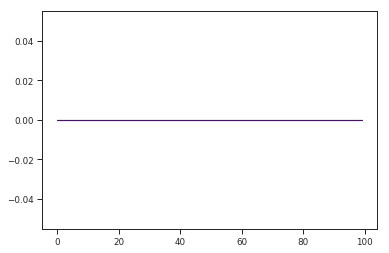

In [17]:
plt.plot(cancer_count)